# 1. Lib Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 2. 전처리

In [3]:
df["count"].max(), df["count"].min()

(np.int64(977), np.int64(1))

In [4]:
# 목적 : 총 대여건수 > 500 ==> 1(many), vs 미만인 경우 0
# 독립변수 데이터로는 [weather, temp, humidity, windspeed]

df['y'] = 1
df.loc[df["count"] < 500, "y"] = 0
df["y"].value_counts()

y
0    10082
1      804
Name: count, dtype: int64

In [5]:
cols = ["weather", "temp", "humidity", "windspeed", "y"]
df_bike = df.loc[:, cols]
df_bike.head()

,weather,temp,humidity,windspeed,y
0,1,9.84,81,0.0,0
1,1,9.02,80,0.0,0
2,1,9.02,80,0.0,0
3,1,9.84,75,0.0,0
4,1,9.84,75,0.0,0


## 2-1. Z-scaling

In [6]:
x = df_bike.loc[:, df_bike.columns[:4]]
y = df_bike["y"]

In [7]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled_bike = pd.DataFrame(data=x_scaled, columns=x.columns)
x_scaled_bike.head()


,weather,temp,humidity,windspeed
0,-0.660178,-1.333661,0.993213,-1.567754
1,-0.660178,-1.438907,0.941249,-1.567754
2,-0.660178,-1.438907,0.941249,-1.567754
3,-0.660178,-1.333661,0.681430,-1.567754
4,-0.660178,-1.333661,0.681430,-1.567754


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_bike, y, test_size=0.3, random_state=27)
x_train.shape, y_train.shape

((7620, 4), (7620,))

# 3. Model 생성과 성능분석

In [9]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(3266,))

In [10]:
test_acc = model.score(x_test, y_test)
print(test_acc)

0.9222290263319045


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report


In [12]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[3012,    0],
       [ 254,    0]])

In [13]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=True)
recall = recall_score(y_test, y_pred, zero_division=True)

print(acc)
print(precision)
print(recall)

0.9222290263319045
1.0
0.0


In [14]:
classifi = classification_report(y_test, y_pred)
print(classifi)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3012
           1       0.00      0.00      0.00       254

    accuracy                           0.92      3266
   macro avg       0.46      0.50      0.48      3266
weighted avg       0.85      0.92      0.88      3266



# 4. Feature 유의성 검정

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_bike, y, test_size=0.3, random_state=27)

In [16]:
import statsmodels.api as sm

In [18]:
x = sm.add_constant(x_train)
logit_model = sm.Logit(y_train, x)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.230217
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7620
Model:                          Logit   Df Residuals:                     7615
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Jan 2025   Pseudo R-squ.:                  0.1119
Time:                        10:17:36   Log-Likelihood:                -1754.3
converged:                       True   LL-Null:                       -1975.4
Covariance Type:            nonrobust   LLR p-value:                 2.032e-94
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9396      0.059    -49.683      0.000      -3.056      -2.824
weather       -0.1404      0.060     -2.322      0.020      -0.259      -0.022
temp           0.7272      0.049     14.778      0.000       0.631       0.824
humidity      -0.4825      0.054     -8.990      0.000      -0.588      -0.377
windspeed      0.0659      0.048      1.386      0.166      -0.027       0.159
==============================================================================
"""

In [19]:
result.params.values

array([-2.93963753, -0.14038828,  0.72716458, -0.48247984,  0.06585532])

In [20]:
np.exp(result.params.values)

array([0.05288489, 0.86902074, 2.06920522, 0.61725081, 1.06807218])

- ML 모델 해석하기 위한 통계모형 해석 방법
  - Summary Table : coef_가 크다는 것은 일단, 영향력이 크다 ==> 회귀분석과 동일
  - coef_(편회귀계수)의 값이 양수라면,
    - 해당 변수의 값이 커질수록 목적변수(Y)가 Ture일 확률, 즉 목표집단이 1(Positive)일 확률이 높아진다.
  - coef_(편회귀계수)의 값이 음수라면,
    - 해당 변수의 값이 커질수록 목적변수(Y)가 False일 확률, 즉 목표집단이 0(Negative)일 확률이 높아진다.
  (중요) : coef_(temp의 경우), 0.7272라는 것은 temp의 값이 1 증가시, 0.7272만큼 증가한다는 것이 아니다.
    - exp(0.7272)증가함을 의미한다. (why? => Logit Transform 수행했기 때문이다 ==> y값의 단위가 Logit이기 때문이다.)

In [23]:
from sklearn.metrics import roc_auc_score

predict_proba = model.predict_proba(x_test)
pr_n, pr_p = predict_proba[:,0], predict_proba[:,1]
print("probability of positive :", pr_p)
roc_score = roc_auc_score(y_test, pr_p )
print("auc score :", roc_score)

probability of positive : [0.01964603 0.01640759 0.08828041 ... 0.14494106 0.31484092 0.08477845]
auc score : 0.7431246144032793


- Auc score 정리
  - 0.7 ~ 0.8 : fair
  - 0.8 ~ 0.9 : good
  - 0.9 over : excellent

In [ ]:
from sklearn.metrics import roc_curve



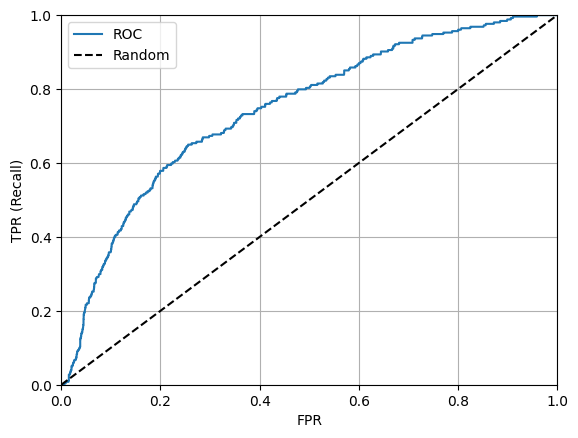

In [29]:
def roc_curve_plot(y_test, pr_p):
    fprs, tprs, thresholds = roc_curve(y_test, pr_p)

    plt.plot(fprs, tprs, label="ROC")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR (Recall)')
    plt.legend()
    plt.grid()
    plt.show()

# ROC 커브 플롯 호출
roc_curve_plot(y_test, pr_p)

# 5. Decision Tree Practice

In [30]:
df_bike.head()

,weather,temp,humidity,windspeed,y
0,1,9.84,81,0.0,0
1,1,9.02,80,0.0,0
2,1,9.02,80,0.0,0
3,1,9.84,75,0.0,0
4,1,9.84,75,0.0,0


In [32]:
cols = list(df_bike.columns[:4])
x = df.loc[:, cols]
y = df["y"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=27)
x_train.shape, y_train.shape

((7620, 4), (7620,))

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=27)
dt_model.fit(x_train, y_train)

dt_model.feature_importances_

array([0.06105782, 0.27903549, 0.33175046, 0.32815622])